In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import re
import io
import matplotlib.pylab as plt
from fa2 import ForceAtlas2
import json
import ast
from collections import Counter
import pickle
import nltk
from nltk import word_tokenize
from tqdm import tqdm, tqdm_notebook
import xml.dom.minidom
from wordcloud import WordCloud
import pprint as pp
import os
import pickle

In [2]:
# imprt our utils
from utils_sg import tokenExtractor, computeTF, computeIDF, getNbUniqueWord, lexical_diversity, frequency_distributions, cumulative_frequency 

In [3]:
data_path = "the-movies-dataset/"
director_popularity_file = "director_pupularity.csv"
sentiment_file = "Happy_words.csv"

In [4]:
metadata = pd.read_csv(data_path+'movies_metadata.csv', encoding ='utf-8')
released = metadata.loc[metadata['status']=='Released']
happy_frame = pd.read_csv(data_path+sentiment_file, encoding ='utf-8')
director_popularity = pd.read_csv(data_path+director_popularity_file, encoding ='utf-8')

/Users/lukaavbreht/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
# Movie lookup tables
kragge_to_imdb_index = dict()
imdb_to_kragge_index = dict()
kragge_to_rel_date = dict()

for ind,row in released.iterrows():
    movie_id = row["id"]
    imdb_id = row["imdb_id"]
    release_date = row["release_date"]
    kragge_to_imdb_index[movie_id] = imdb_id
    imdb_to_kragge_index[imdb_id] = movie_id
    kragge_to_rel_date[movie_id] = release_date


In [6]:
# happines score lookup table
happines_score_dict = dict()
for val in happy_frame["word"]:
    happines_score_dict[val.lower()] = happy_frame[happy_frame["word"] == val]["happiness_average"].values[0]

In [7]:
def sentiment(token_list):
    """
    Returns the calculated sentiment value of list of tokens based on the happines list of words from 
    [Temporal Patterns of Happiness and Information in a Global Social Network: Hedonometrics and Twitter]
    (http://journals.plos.org/plosone/article? id=10.1371/journal.pone.0026752)
    """
    if len(token_list) == 0:
        return 0
    res = 0
    for token in token_list:
        token = token.lower()
        if token in happines_score_dict:
            res += happines_score_dict[token]
    return res/len(token_list)

In [8]:
# get list of moves we are using
# only directors with a vote count over 500
director_popularity_small = director_popularity.loc[director_popularity['vote_count'] >= 500]

# get all movies from these directors
l = list(director_popularity_small['work'])
movies = []
for sublist in l:
    sublist = ast.literal_eval(sublist)
    for item in sublist:
        movies.append(item)

In [56]:
# We are using pickle to save already parsed and generated data that would otherwise 
# take many hours to just run one notebook
movie_to_sentiment_pickle_file = "movie_to_sentiment_pickle.pickle"

In [57]:
# Sentiment of all movies


if not os.path.isfile(movie_to_sentiment_pickle_file):
    movie_to_sentiment_score = dict()
    movie_to_sentiment_score_imdb = dict()

    movie_to_tokens = dict()

    sub_data_path = "../../CopySubs/"
    file_name_temp = "{0}.xml"

    not_score = 0
    exist = 0

    for movie_k in tqdm_notebook(movies, unit="movies"):
        movie = kragge_to_imdb_index[str(movie_k)]
        if str(movie) != "nan":
            imdb_id = int(str(movie)[2:])
            xml_file = sub_data_path+file_name_temp.format(imdb_id)
            if os.path.isfile(xml_file):
                tokenized_subs = tokenExtractor(xml_file)
                movie_to_tokens[movie_k] = tuple(tokenized_subs)
                exist += 1
                sentiment_score = sentiment(tokenized_subs)

                movie_to_sentiment_score[movie_k] = sentiment_score
                movie_to_sentiment_score_imdb[movie] = sentiment_score
            else:
                not_score += 1
                
    data = [movie_to_sentiment_score,
    movie_to_sentiment_score_imdb,
    movie_to_tokens]
    with open(movie_to_sentiment_pickle_file, 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open(movie_to_sentiment_pickle_file, 'rb') as handle:
        data = pickle.load(handle)
    movie_to_sentiment_score,movie_to_sentiment_score_imdb,movie_to_tokens = data
    

    


In [11]:
# Sentiment of all movies in one array (distribution)

Text(0.5, 1.0, 'Distribution of movie sentiments')

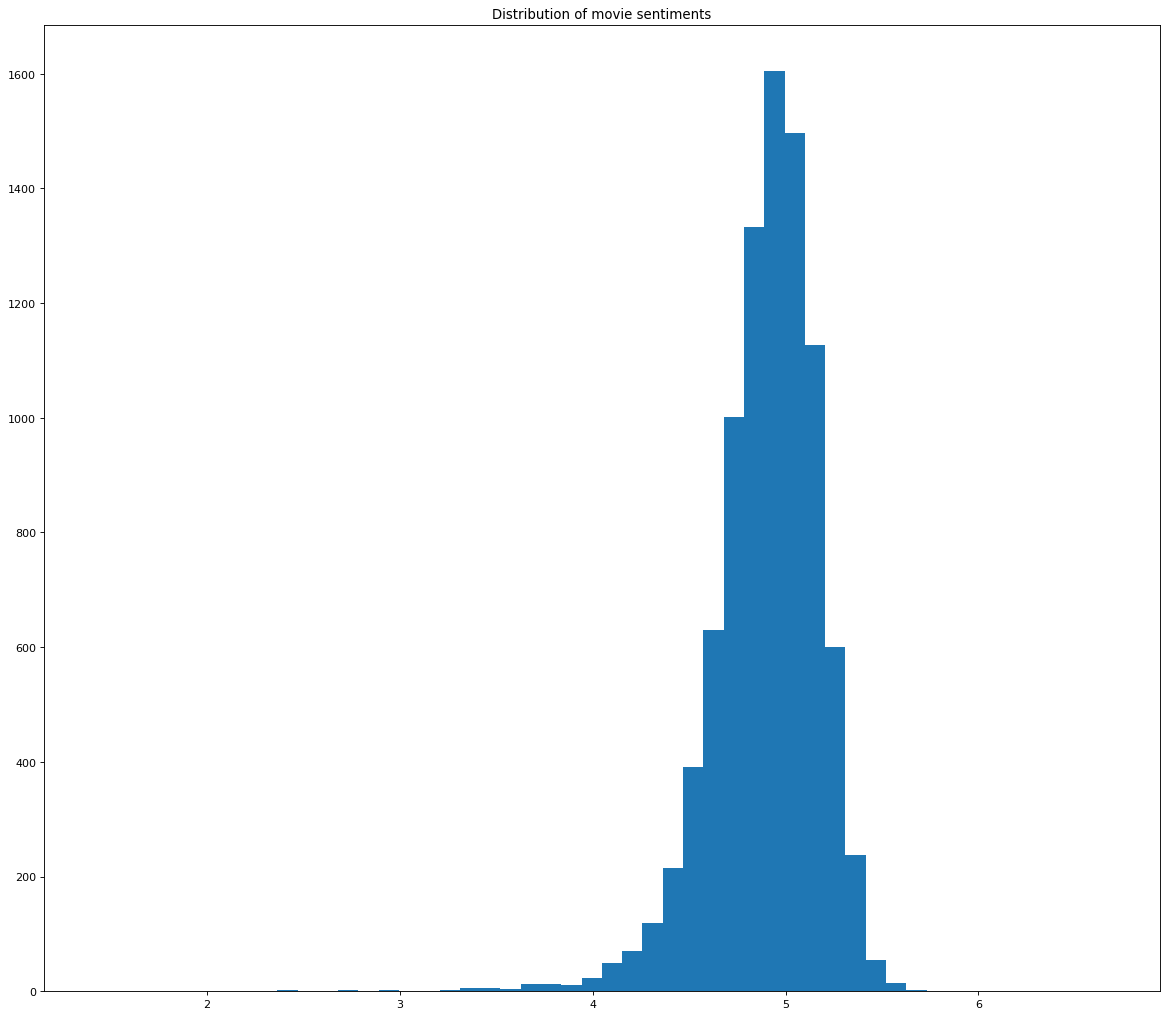

In [12]:
# happy/sad movie outliers 
# some titles of those movies
# word cloud for each of them

# Load precomputed sentiment scores of moves using sentiment function
all_movies_sentiment = [movie_to_sentiment_score[i] for i in movie_to_sentiment_score.keys()]

# plot the histogram of this distribution
plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.hist(all_movies_sentiment, bins=50)
plt.title("Distribution of movie sentiments")

In [13]:
# Numerical values of normally distributed data using numpy
all_movies_sentiment_nparray = np.array(all_movies_sentiment)
all_movie_avrg = all_movies_sentiment_nparray.mean()
all_movie_stdev = all_movies_sentiment_nparray.std()

print("Average sentiment of movies is: {0:.4f}".format(all_movie_avrg))
print("Standard deviation of movies is: {0:.4f}".format(all_movie_stdev))

Average sentiment of movies is: 4.8984
Standard deviation of movies is: 0.2850


In [14]:
# Get happy and sad movies:
sad_movies = list()
happy_movies = list()

# Go over all movies and pickout the outliers
for movie in movie_to_sentiment_score.keys():
    if movie_to_sentiment_score[movie] < all_movie_avrg - 2*all_movie_stdev:
        # If movie is considered sad, ie if it has a sentiment score bellow mean - 2*stdev
        sad_movies.append(movie)
    elif movie_to_sentiment_score[movie] > all_movie_avrg + 2*all_movie_stdev:
        # if movie is consideret happy
        happy_movies.append(movie)

print("There are {0} sad movies.".format(len(sad_movies)))
print("There are {0} happy movies.".format(len(happy_movies)))

There are 277 sad movies.
There are 37 happy movies.


In [15]:
# Path and file name templates used for parsing
sub_data_path = "../../CopySubs/"
file_name_temp = "{0}.xml"

In [16]:
# create sad movies word clowd 
sad_tokens = list()
for sad_m in tqdm_notebook(sad_movies,unit="movies"):
    movie = kragge_to_imdb_index[str(sad_m)]
    if str(movie) != "nan":
        imdb_id = int(str(movie)[2:])
        xml_file = sub_data_path+file_name_temp.format(imdb_id)
        if os.path.isfile(xml_file):
            sad_tokens += tokenExtractor(xml_file)      

In [17]:
happy_tokens = list()
for sad_m in tqdm_notebook(happy_movies,unit="movies"):
    movie = kragge_to_imdb_index[str(sad_m)]
    if str(movie) != "nan":
        imdb_id = int(str(movie)[2:])
        xml_file = sub_data_path+file_name_temp.format(imdb_id)
        if os.path.isfile(xml_file):
            happy_tokens += tokenExtractor(xml_file)

We compute the unique words and TF of token lists using functions defined in utils. For that see utils notebook explanation.

We do as follows:
* compute count for all unique words aka count them
* compute TF of token list using the token count and original list
* Join all token lists in one list of lists and compute its's idfs
* Using those two results we are able to compute tf-ids for each token list
* We then reperesent them using word clouds. 

This process is more or less the same when we generate wordclouds to get an additional inside to text

In [18]:
# sad movies ids
sad_token_count = getNbUniqueWord(sad_tokens)
sad_tfs = computeTF(sad_token_count, sad_tokens)

In [19]:
# happy movie ids
happy_token_count = getNbUniqueWord(happy_tokens)
happy_tfs = computeTF(happy_token_count, happy_tokens)

In [20]:
idfs = computeIDF([sad_token_count,happy_token_count])

sad_tfidfs = dict()
happy_tfidfs = dict()


for word in sad_tfs:
    sad_tfidfs[word] = sad_tfs[word] * idfs[word]

for word in happy_tfs:
    happy_tfidfs[word] = happy_tfs[word] * idfs[word]
    

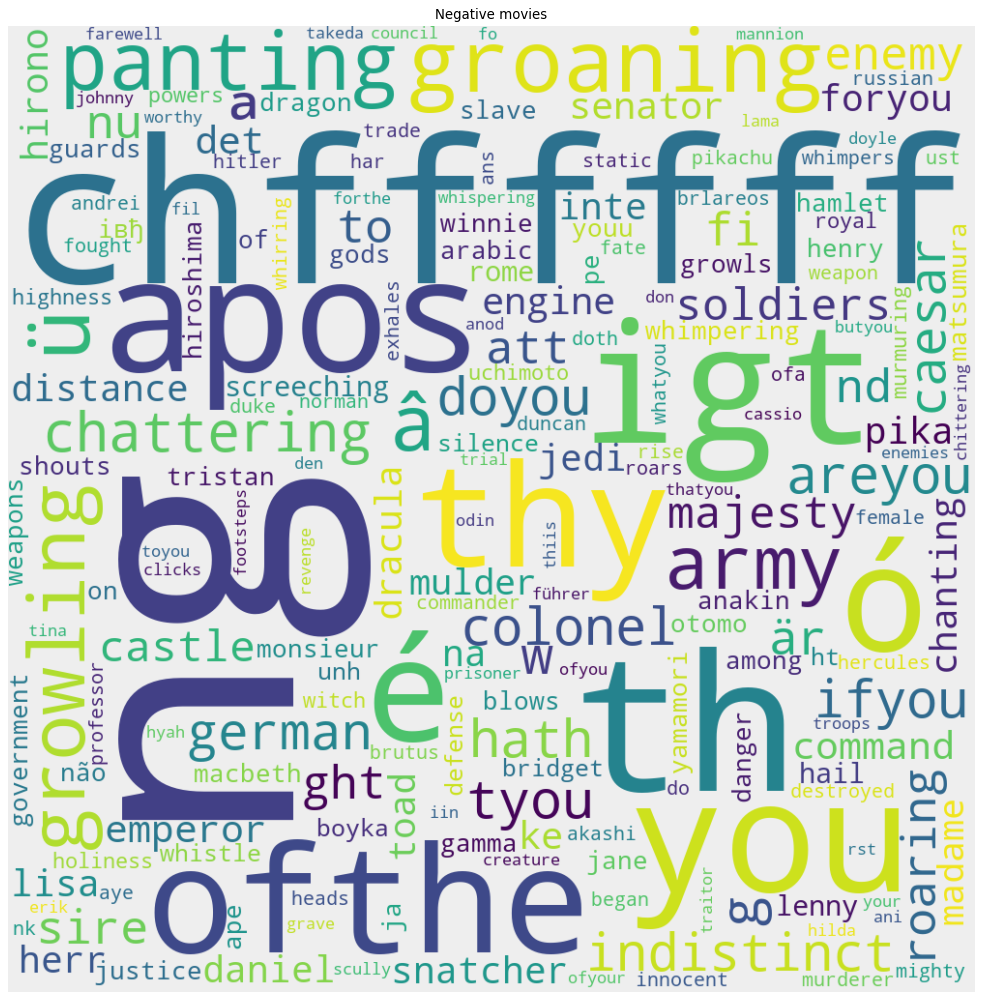

In [21]:
wordcloud = WordCloud(width=1000, height=1000, background_color="#EEEEEE").generate_from_frequencies(sad_tfidfs)

plt.figure(figsize=(18, 16), dpi=80)
plt.imshow(wordcloud, interpolation="bilinear")
plt.title("Negative movies")
plt.axis("off")
plt.show()

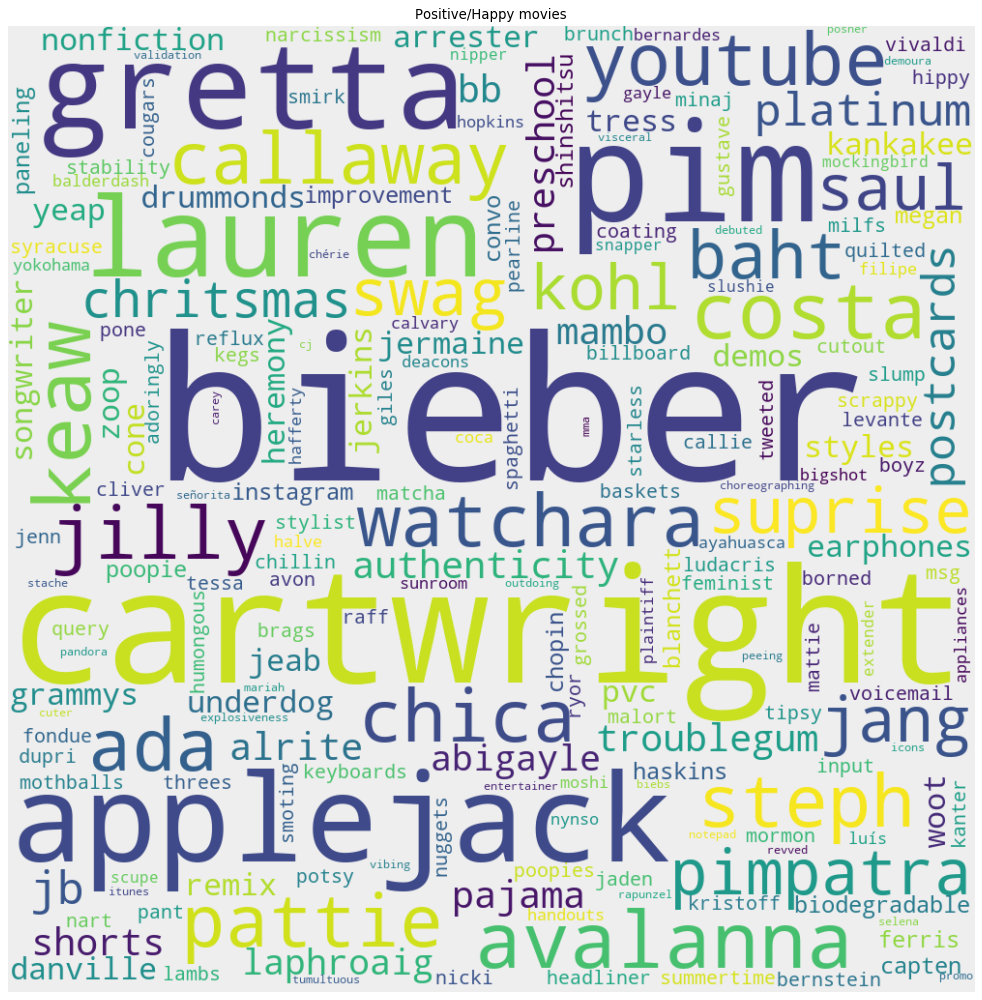

In [23]:
wordcloud = WordCloud(width=1000, height=1000, background_color="#EEEEEE").generate_from_frequencies(happy_tfidfs)

plt.figure(figsize=(18, 16), dpi=80)
plt.imshow(wordcloud, interpolation="bilinear")
plt.title("Positive/Happy movies")
plt.axis("off")
plt.show()

In [24]:
# pickle filename
pickle_filename = "dirctor_sentiment_pickle.pickle"

In [25]:
# sentiment by director
# distribution
# again sad/happy directors

# Again load director data and from file if there is no pregenerated pickle file
# Otherwise we just load pickle file
if not os.path.isfile(pickle_filename):
    directors_to_sentiment = dict()
    director_to_work = dict()
    directors_to_token_list_work = dict()
    directors_to_diverity = dict()
    directors_to_freq_dist = dict()


    for ind,row in tqdm_notebook(director_popularity_small.iterrows(), unit= "director"):
        sublist = row["work"]
        director = row["director"]
        sublist = ast.literal_eval(sublist)
        ssum = 0
        movie_count = 0
        temp_work = tuple()
        temp_dir_tokens = list()
        for item in sublist:
            if item in movie_to_sentiment_score:
                ssum += movie_to_sentiment_score[item]
                movie_count += 1
                temp_work += (item,)
            if movie_count != 0:
                directors_to_sentiment[director] = ssum/movie_count
                director_to_work[director] = temp_work
            if item in movie_to_tokens:
                temp_dir_tokens += list(movie_to_tokens[item])
        directors_to_token_list_work[director] = tuple(temp_dir_tokens)
        try:
            lex_div = lexical_diversity(temp_dir_tokens)
        except:
            lex_div = 0
        directors_to_diverity[director] = lex_div
        directors_to_freq_dist[director] = frequency_distributions(temp_dir_tokens)
        
    data = [directors_to_sentiment,
    director_to_work,
    directors_to_token_list_work,
    directors_to_diverity,
    directors_to_freq_dist]
    with open(pickle_filename, 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open(pickle_filename, 'rb') as handle:
        data = pickle.load(handle)
    directors_to_sentiment,director_to_work,directors_to_token_list_work,directors_to_diverity,directors_to_freq_dist = data
    

Text(0.5, 1.0, 'Distribution of director work sentiments')

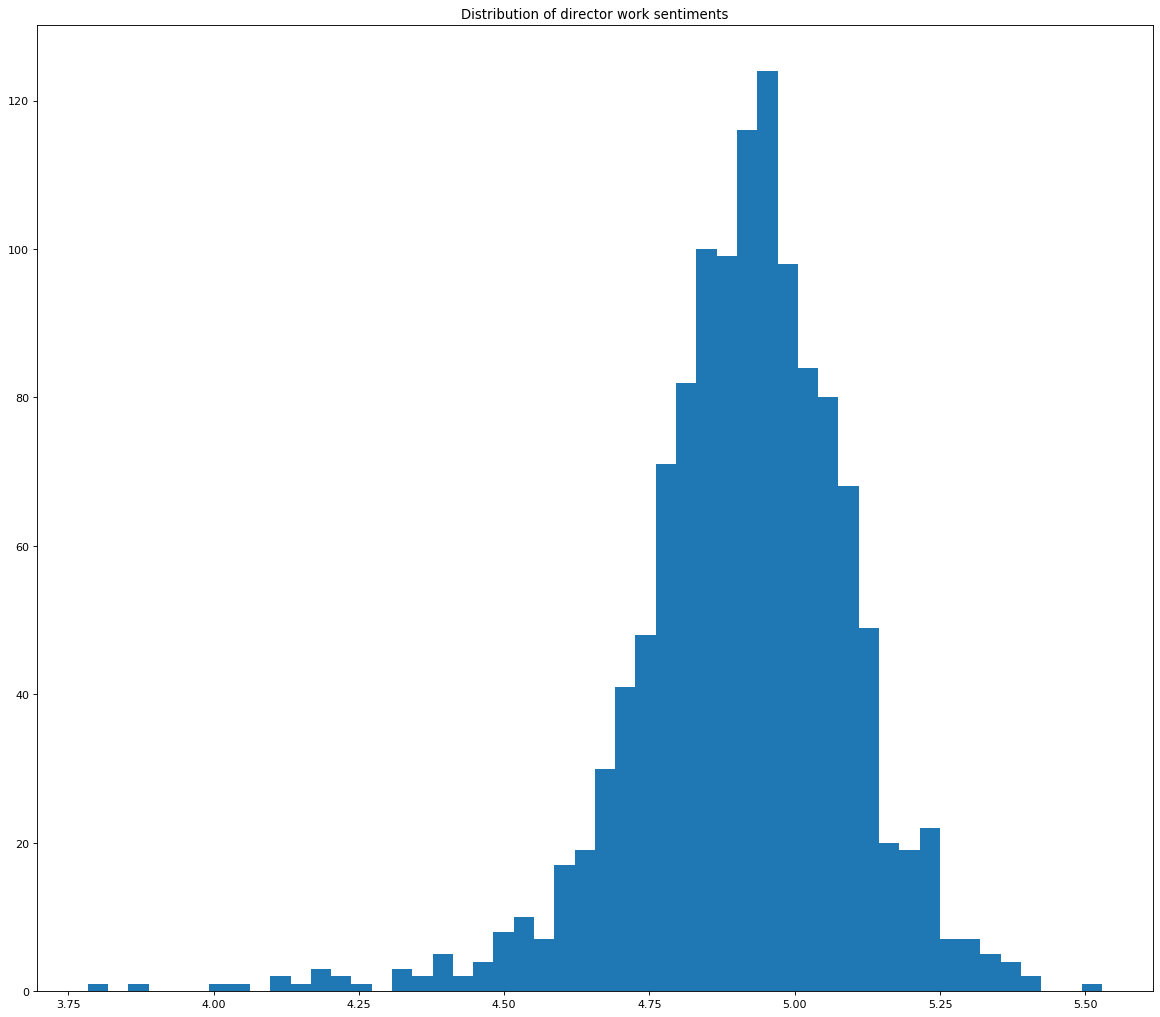

In [26]:
# Simmilar to movie sentiment analysis
director_sentiment = [directors_to_sentiment[i] for i in directors_to_sentiment.keys()]

plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.hist(director_sentiment, bins=50)
plt.title("Distribution of director work sentiments")

In [27]:
# Numerical values for normaly distributed set
director_sentiment_nparray = np.array(director_sentiment)
director_sentiment_avrg = director_sentiment_nparray.mean()
director_sentiment_stdev = director_sentiment_nparray.std()

print("Average sentiment of directors work is: {0:.4f}".format(director_sentiment_avrg))
print("Standard deviation of directors work is: {0:.4f}".format(director_sentiment_stdev))

Average sentiment of directors work is: 4.9084
Standard deviation of directors work is: 0.1878


In [28]:
# Get happy and sad directors:
sad_directors = list()
happy_directors = list()

for director in directors_to_sentiment.keys():
    if directors_to_sentiment[director] < director_sentiment_avrg - 2*director_sentiment_stdev:
        sad_directors.append(director)
    elif directors_to_sentiment[director] > director_sentiment_avrg + 2*director_sentiment_stdev:
        happy_directors.append(director)

print("There are {0} sad directors.".format(len(sad_directors)))
pp.pprint(sad_directors)
print("There are {0} happy directors.".format(len(happy_directors)))
pp.pprint(happy_directors)

There are 43 sad directors.
['George Lucas',
 'John Lasseter',
 'Stephen Sommers',
 'James McTeigue',
 'Clyde Geronimi',
 'Dean DeBlois',
 'Henry Selick',
 'John Hillcoat',
 'Jim Abrahams',
 'Peter Sohn',
 'Tony Bancroft',
 'Scott Stewart',
 'Rob Bowman',
 'Anna Foerster',
 'André Øvredal',
 'Carl Rinsch',
 'Lauren Montgomery',
 'Jean-Marie Poiré',
 'Peter Webber',
 'Kinji Fukasaku',
 'Ted Berman',
 'Doug Sweetland',
 'Jake Szymanski',
 'Philippe Lacheau',
 'Shinji Aramaki',
 'Ethan Spaulding',
 'Georges Méliès',
 'Peggy Holmes',
 'David Sandberg',
 'Hideaki Anno',
 'John Kahrs',
 'Paul Tibbitt',
 'Anthony Stacchi',
 'Joe Lynch',
 'Adam Elliot',
 'Stephen Hillenburg',
 'Gabriele Mainetti',
 'Alastair Fothergill',
 'Sebastián Cordero',
 'Dennis Iliadis',
 'Michael Haigney',
 'Laura Poitras',
 'Kunihiko Yuyama']
There are 19 happy directors.
['Chris Buck',
 'Chris Renaud',
 'Stephen Chbosky',
 'John Carney',
 'Wally Pfister',
 'David Robert Mitchell',
 'Joseph Gordon-Levitt',
 'David F. 

In [29]:
# Sad directors wordcloud
sad_tokens = list()
for sad_dir in tqdm_notebook(sad_directors,unit="directors"):
    for movie in director_to_work[sad_dir]:
        movie = kragge_to_imdb_index[str(movie)]
        if str(movie) != "nan":
            imdb_id = int(str(movie)[2:])
            xml_file = sub_data_path+file_name_temp.format(imdb_id)
            if os.path.isfile(xml_file):
                sad_tokens += tokenExtractor(xml_file)

In [30]:
# Happy directors wordcloud
happy_tokens = list()
for happy_dir in tqdm_notebook(happy_directors,unit="directors"):
    for movie in director_to_work[happy_dir]:
        movie = kragge_to_imdb_index[str(movie)]
        if str(movie) != "nan":
            imdb_id = int(str(movie)[2:])
            xml_file = sub_data_path+file_name_temp.format(imdb_id)
            if os.path.isfile(xml_file):
                happy_tokens += tokenExtractor(xml_file)

In [31]:
# sad director ids
sad_token_count = getNbUniqueWord(sad_tokens)
sad_tfs = computeTF(sad_token_count, sad_tokens)

In [32]:
# happy direcotr ids
happy_token_count = getNbUniqueWord(happy_tokens)
happy_tfs = computeTF(happy_token_count, happy_tokens)

In [33]:
idfs = computeIDF([sad_token_count,happy_token_count])

sad_tfidfs = dict()
happy_tfidfs = dict()


for word in sad_tfs:
    sad_tfidfs[word] = sad_tfs[word] * idfs[word]

for word in happy_tfs:
    happy_tfidfs[word] = happy_tfs[word] * idfs[word]
    

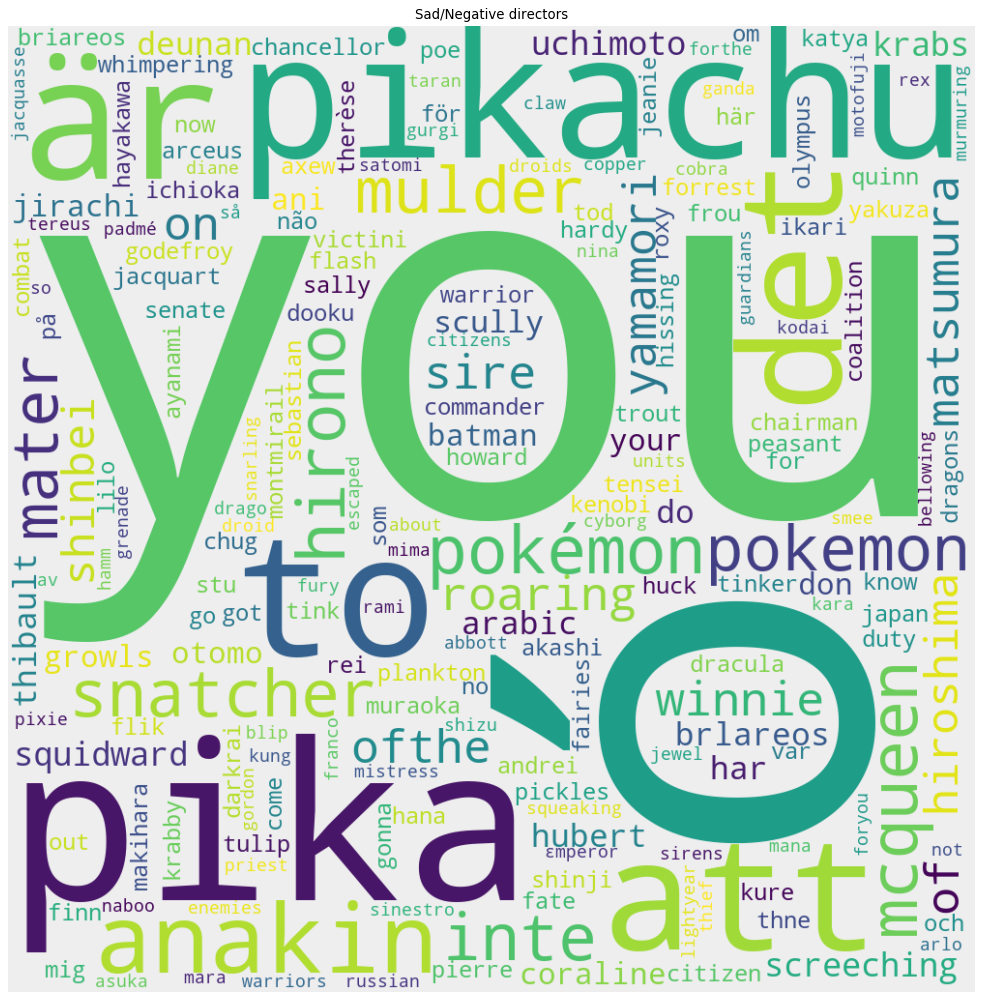

In [34]:
wordcloud = WordCloud(width=1000, height=1000, background_color="#EEEEEE").generate_from_frequencies(sad_tfidfs)

plt.figure(figsize=(18, 16), dpi=80)
plt.imshow(wordcloud, interpolation="bilinear")
plt.title("Sad/Negative directors")
plt.axis("off")
plt.show()

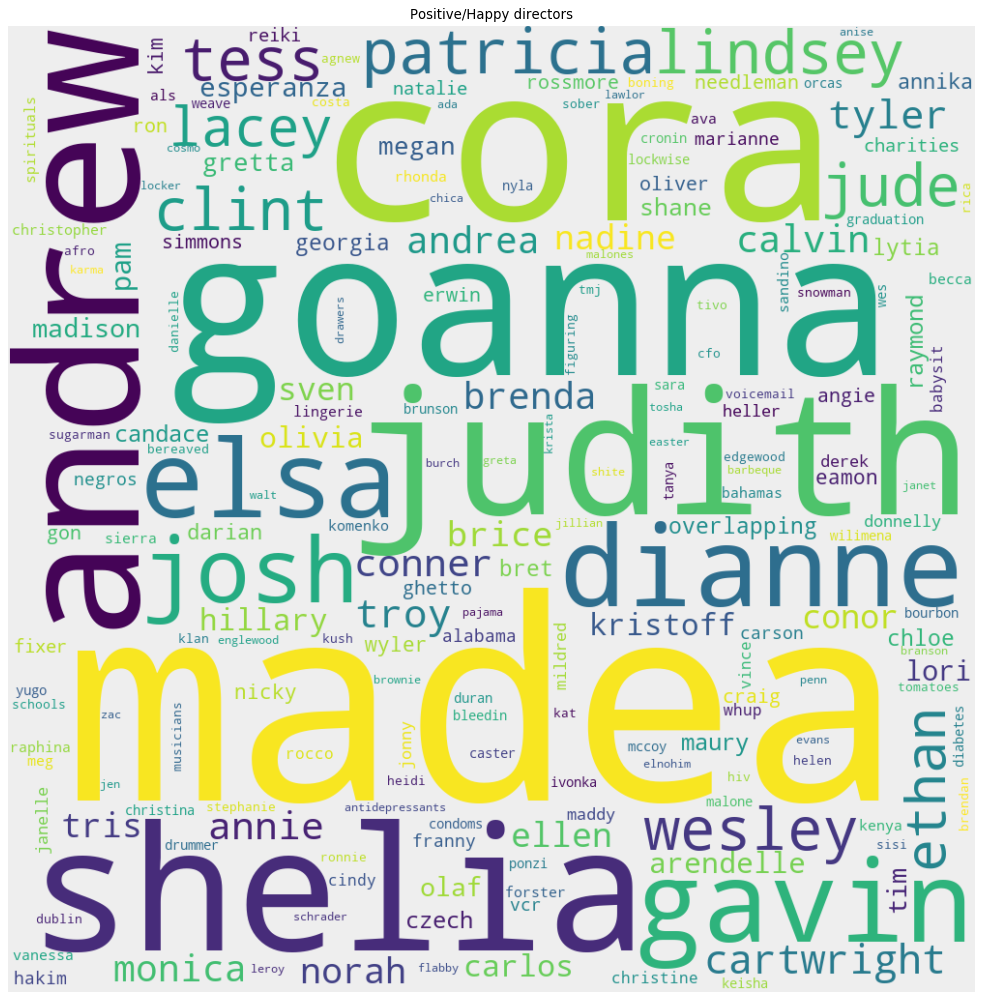

In [35]:
wordcloud = WordCloud(width=1000, height=1000, background_color="#EEEEEE").generate_from_frequencies(happy_tfidfs)

plt.figure(figsize=(18, 16), dpi=80)
plt.imshow(wordcloud, interpolation="bilinear")
plt.title("Positive/Happy directors")
plt.axis("off")
plt.show()

In [36]:
# Famus directors with many movies
# sentiment of thheir movies

# How do famus directors do compared to others

# We get choose this three directors based on analysis did in network analysis part

central_directors = ["Ridley Scott","Woody Allen","Steven Spielberg"]

In [37]:
# We initially just check the numerical values of directors sentiment
for director in central_directors:
    print("{0} has a average sentiment of {1:.3f}".format(director,directors_to_sentiment[director]))

Ridley Scott has a average sentiment of 4.819
Woody Allen has a average sentiment of 4.998
Steven Spielberg has a average sentiment of 4.799


Text(0.5, 1.0, 'Distribution of director work sentiments with Central directors')

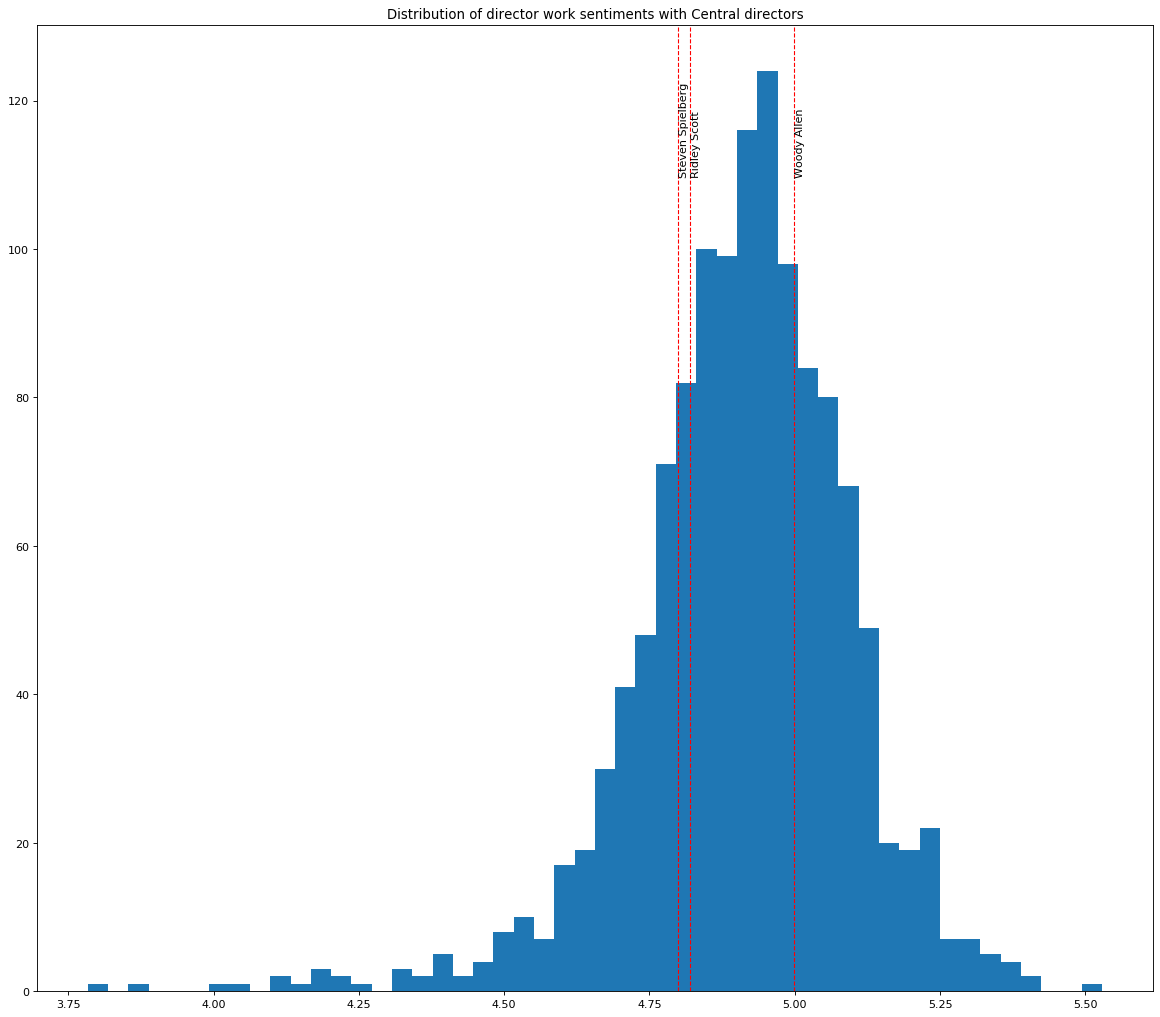

In [38]:
# Sentiment analysis of directors
director_sentiment = [directors_to_sentiment[i] for i in directors_to_sentiment.keys()]

plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.hist(director_sentiment, bins=50)
for director in central_directors:
    plt.axvline(directors_to_sentiment[director], color='r', linestyle='dashed', linewidth=1)
    plt.text(directors_to_sentiment[director] + 0.003,110,director,rotation=90,color="black")

plt.title("Distribution of director work sentiments with Central directors")


In [39]:
# Check if they are special (using word clouds)
director_tokens_list = [list() for _ in central_directors]
# Sad directors wordcloud
ind = 0
for director in tqdm_notebook(central_directors,unit="directors"):
    for movie in director_to_work[director]:
        movie = kragge_to_imdb_index[str(movie)]
        if str(movie) != "nan":
            imdb_id = int(str(movie)[2:])
            xml_file = sub_data_path+file_name_temp.format(imdb_id)
            if os.path.isfile(xml_file):
                director_tokens_list[ind] += tokenExtractor(xml_file)
    ind += 1

In [40]:
# Compute wordlouds for the central directors 
all_dir_tokens = list()
dir_token_count = [None for _ in range(len(central_directors))]
dir_tfs = [None for _ in range(len(central_directors))]
ind = 0
for dir_tokens in director_tokens_list:
    dir_token_count[ind] = getNbUniqueWord(dir_tokens)
    all_dir_tokens.append(dir_token_count[ind])
    dir_tfs[ind] = computeTF(dir_token_count[ind], dir_tokens)
    ind+=1


In [41]:
dir_idfs = computeIDF(all_dir_tokens)
dir_tf_idfs = [dict() for _ in range(len(central_directors))]

for ind,direc in enumerate(central_directors):
    for word in dir_tfs[ind]:
        dir_tf_idfs[ind][word] = dir_tfs[ind][word] * dir_idfs[word]


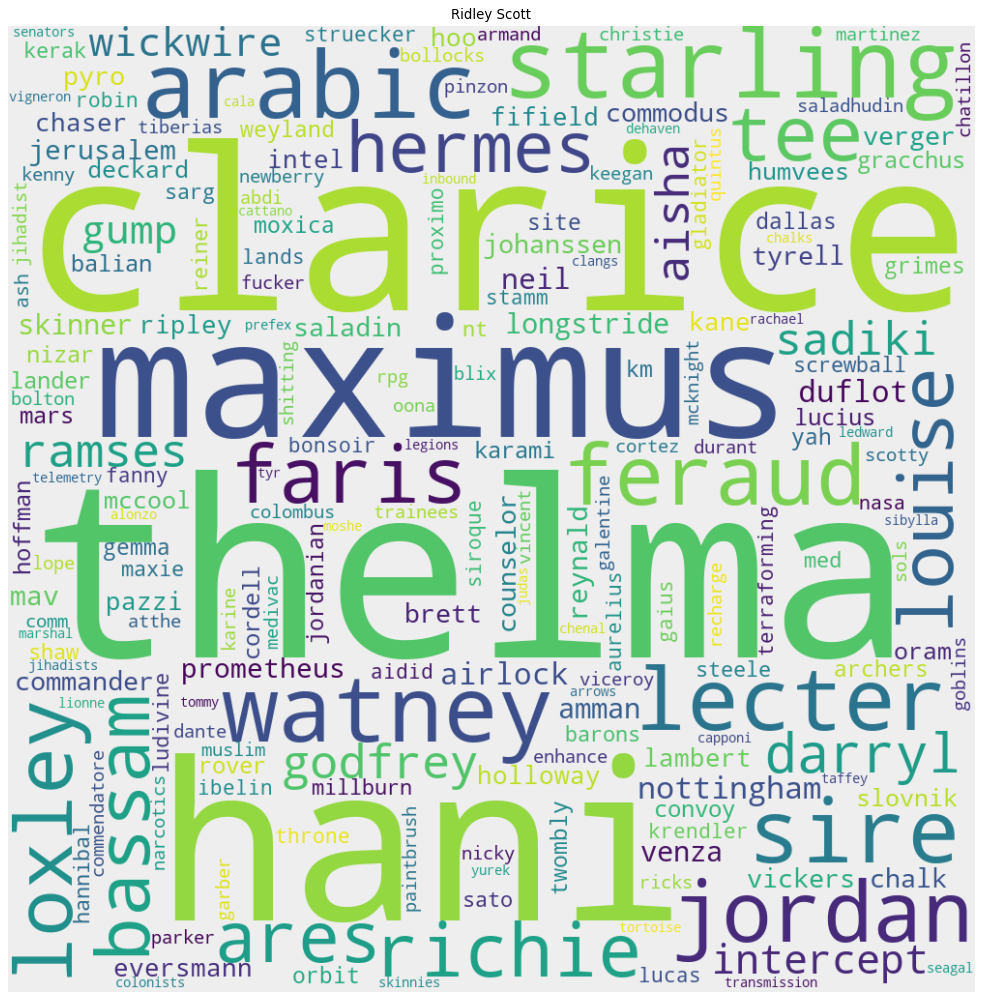

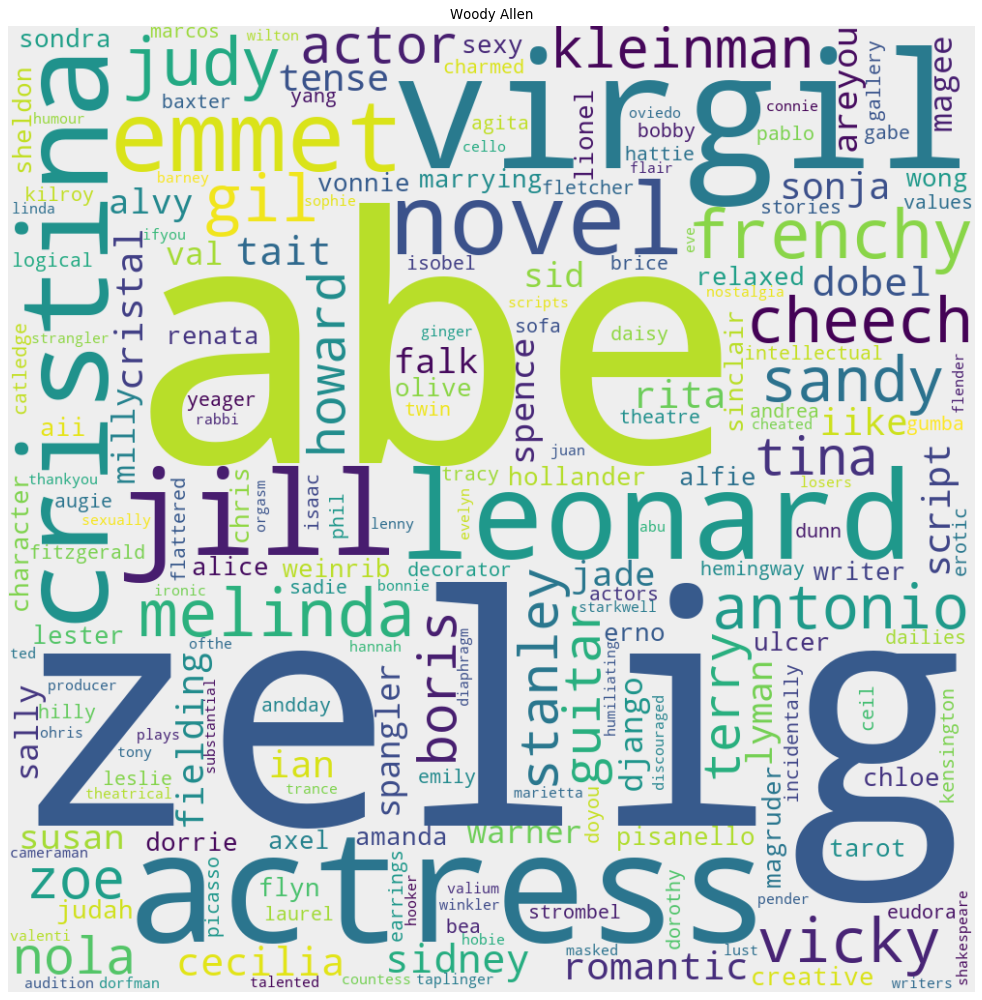

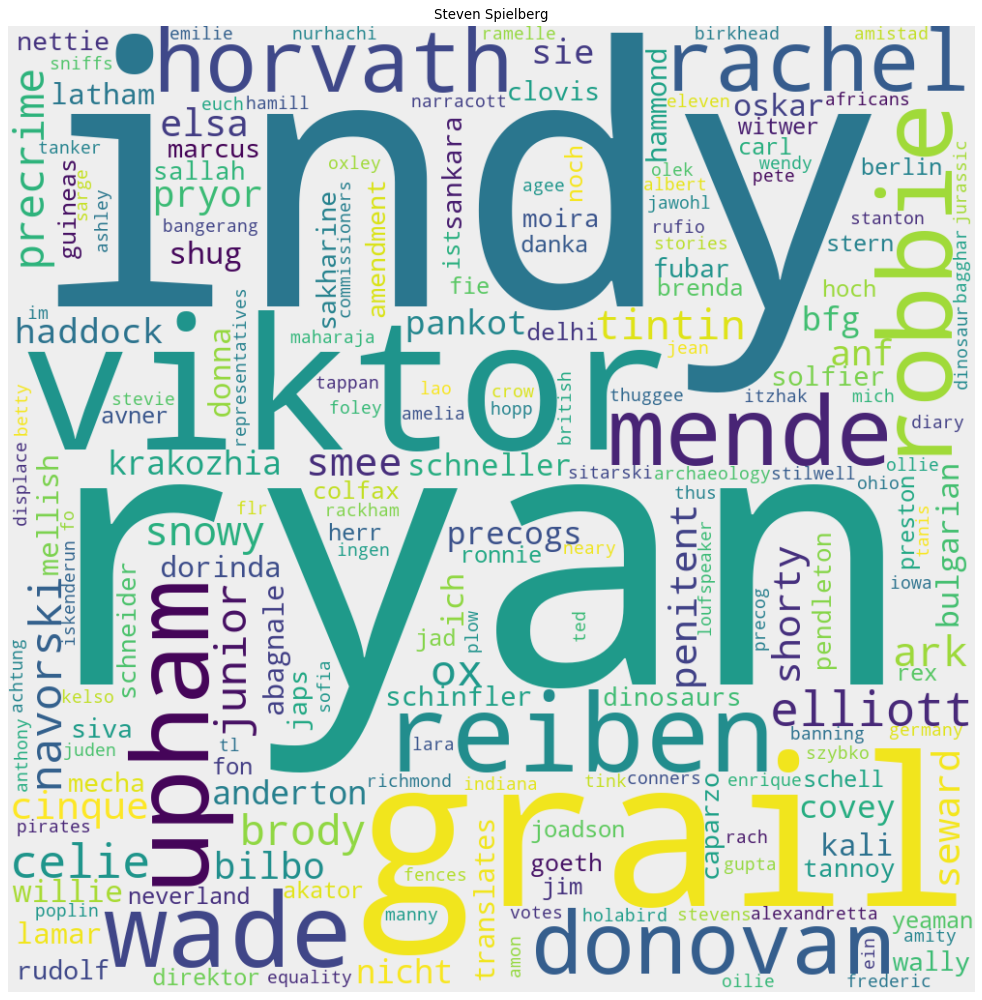

In [42]:
for ind,dir_dfid in enumerate(dir_tf_idfs):

    wordcloud = WordCloud(width=1000, height=1000, background_color="#EEEEEE").generate_from_frequencies(dir_dfid)

    plt.figure(figsize=(18, 16), dpi=80)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(central_directors[ind])
    plt.axis("off")
    plt.show()

In [43]:
# diversity of the language used by directors



We compute language diversity by comparing the number of unique words with the number of all words used in director's work. We do that using fuction in utils file. For mor information on thet check the utility folder or their explanatory notebook

Text(0.5, 1.0, 'Distribution of Director work lanquage diversity')

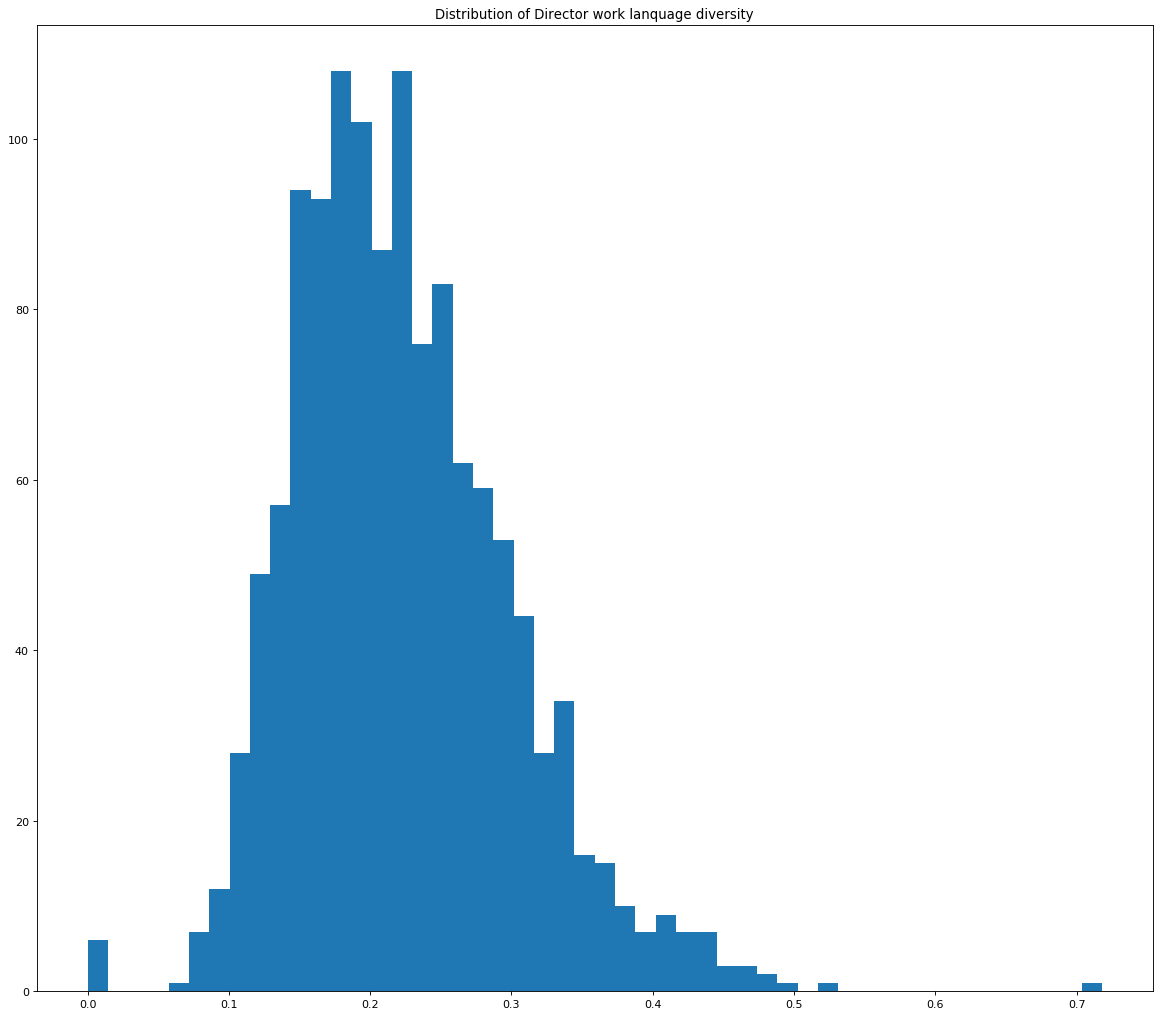

In [44]:
# Diversity analysis of directors
director_diversity_plot = [directors_to_diverity[i] for i in directors_to_diverity.keys()]

plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.hist(director_diversity_plot, bins=50)
plt.title("Distribution of Director work lanquage diversity")

In [45]:
director_diversity_nparray = np.array(director_diversity_plot)
director_diversity_avrg = director_diversity_nparray.mean()
director_diversity_stdev = director_diversity_nparray.std()

print("Average language diversity of directors work is: {0:.4f}".format(director_diversity_avrg))
print("Standard language diversity of directors work is: {0:.4f}".format(director_diversity_stdev))

Average language diversity of directors work is: 0.2229
Standard language diversity of directors work is: 0.0770


Text(0.5, 1.0, 'Distribution of Director work lanquage diversity')

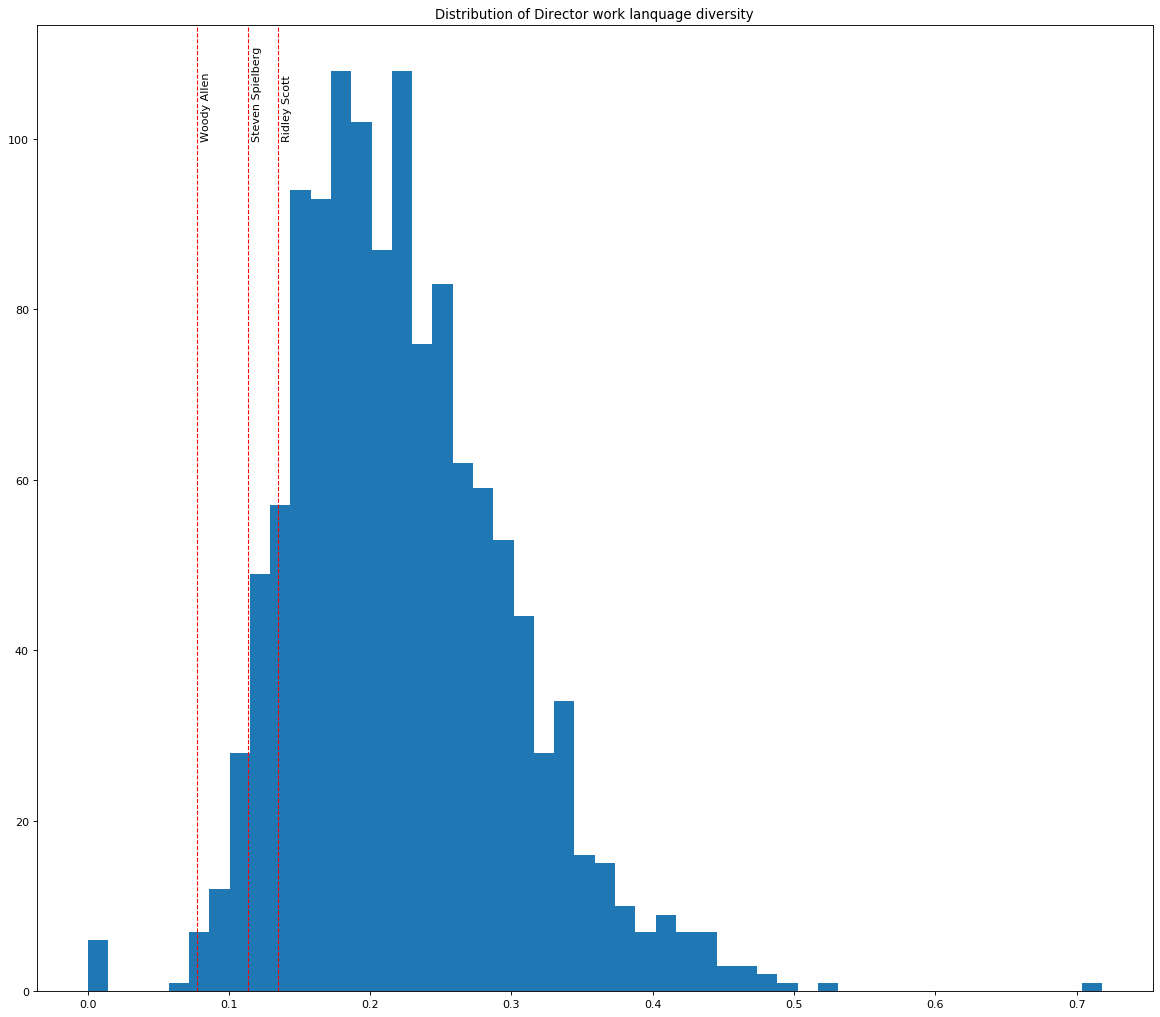

In [59]:
# Sentiment analysis of directors
director_diversity_plot = [directors_to_diverity[i] for i in directors_to_diverity.keys()]

plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.hist(director_diversity_plot, bins=50)
for director in central_directors:
    plt.axvline(directors_to_diverity[director], color='r', linestyle='dashed', linewidth=1)
    plt.text(directors_to_diverity[director] + 0.003,100,director,rotation=90,color="black")
plt.title("Distribution of Director work lanquage diversity")

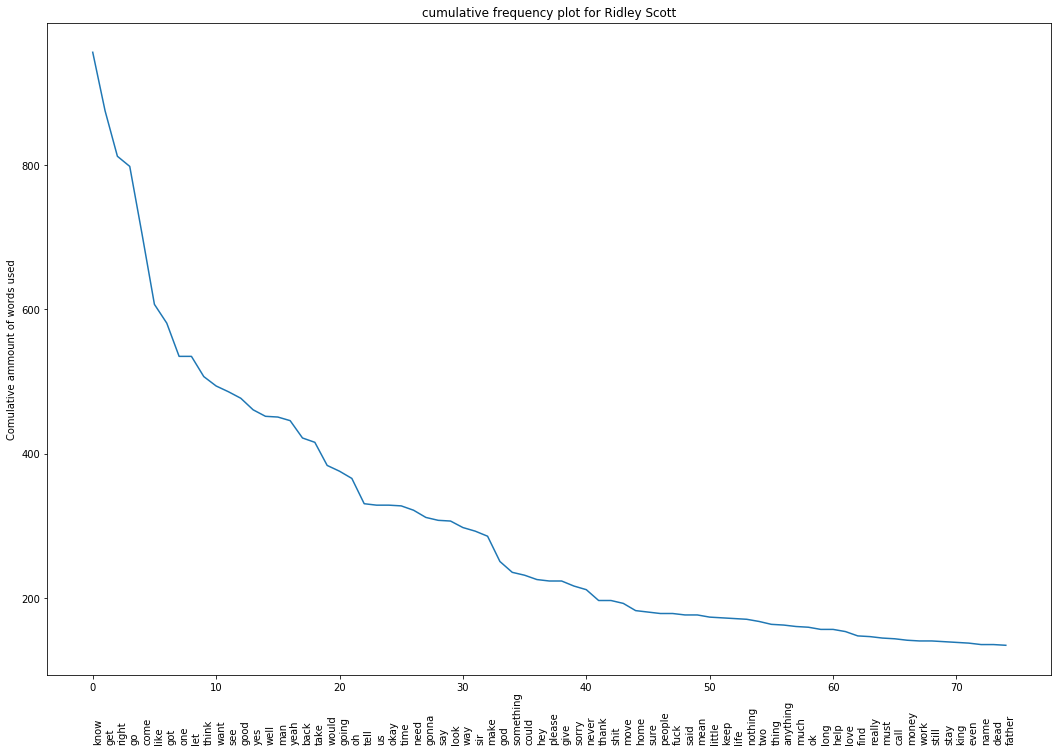

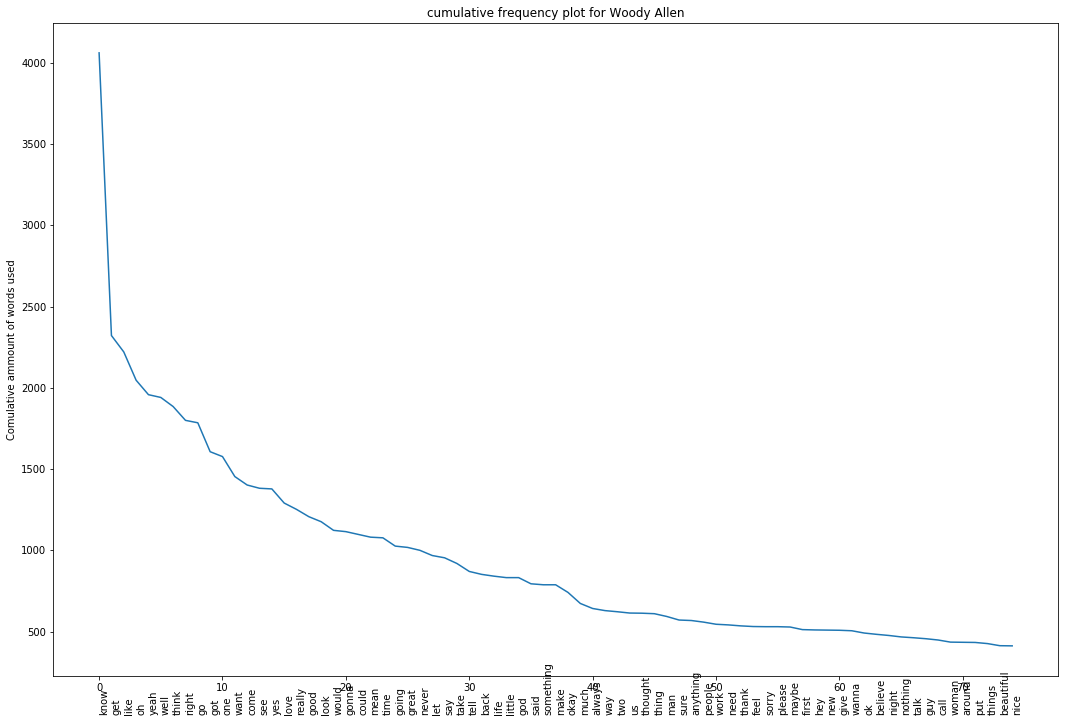

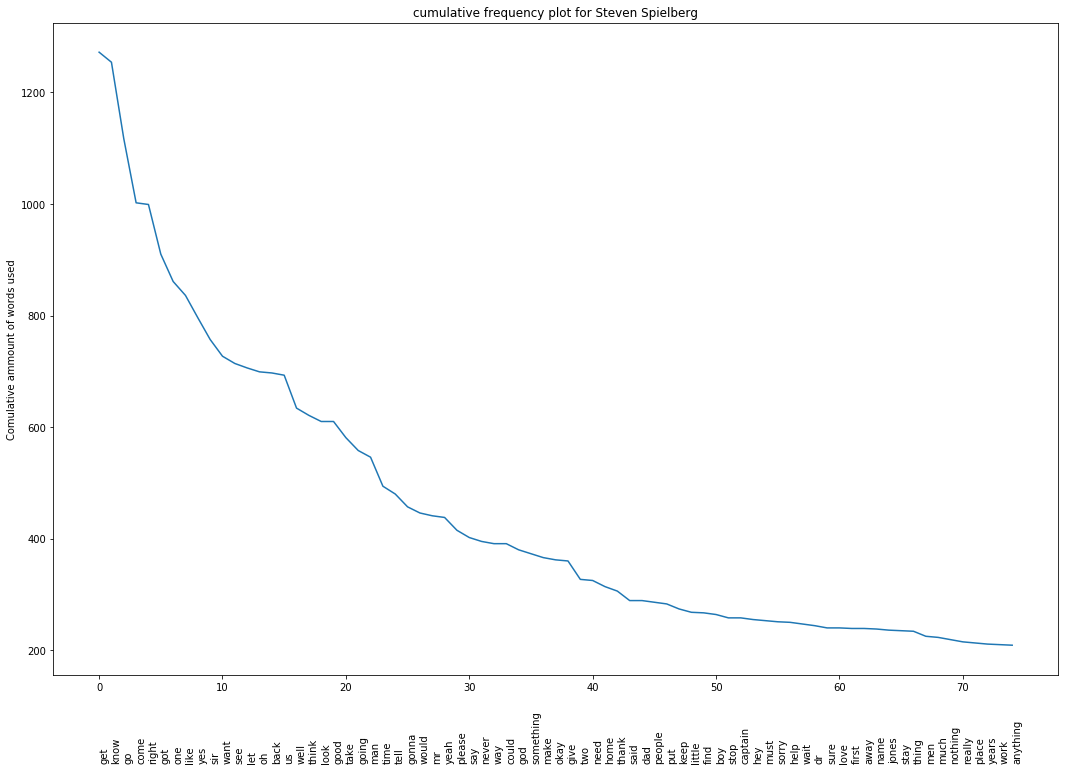

In [47]:
# Lets se how our top directors use language in their work

for ind,ddir in enumerate(central_directors):
    
    to_plot_list = directors_to_freq_dist[ddir]
    act_plot = [i[0] for i in to_plot_list]
    plt.figure(figsize=(18, 12))
    plt.plot(act_plot)
    # plt.xlabel('Number of unique words (form most common one to least common one)')
    plt.ylabel('Comulative ammount of words used')
    plt.title("cumulative frequency plot for {0}".format(ddir))
    for ind,i in enumerate(to_plot_list):
        plt.text(ind,0,i[1],rotation=90,color="black")
    plt.show()


In [48]:
# words over time for all movies?
all_movies_over_time = list()

# Firs of all we sort movies based on their release date
ordered_movies_by_rel_date = list()
print("Creating list to sort")
for movie_k in tqdm_notebook(movies, unit="movies"):
    ordered_movies_by_rel_date.append((kragge_to_rel_date[str(movie_k)],movie_k))
    
ordered_movies_by_rel_date.sort()

print("Preparing token list")
for rel_date,movie_k in tqdm_notebook(ordered_movies_by_rel_date, unit="movies"):
    if movie_k in movie_to_tokens:
        all_movies_over_time += list(movie_to_tokens[movie_k])

# We then create nltk text so we can use build in nltk functions on that class
nltk_all_movies_over_time = nltk.Text(all_movies_over_time)

Creating list to sort



Preparing token list


In [49]:
# Checkout the nltk text object
nltk_all_movies_over_time

<Text: trip moon george melies astronomers assembled large hall...>

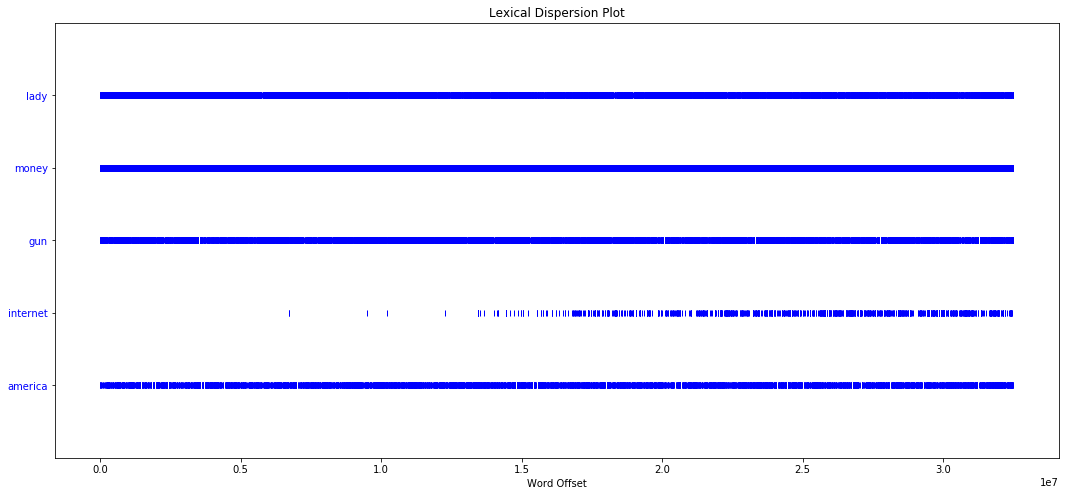

In [50]:
# Plot the lexical dispersity plot for some words) 
plt.figure(figsize=(18, 8)) #, dpi= 80, facecolor='w', edgecolor='k')
fig = nltk_all_movies_over_time.dispersion_plot(["lady", "money", "gun", "internet", "america"])

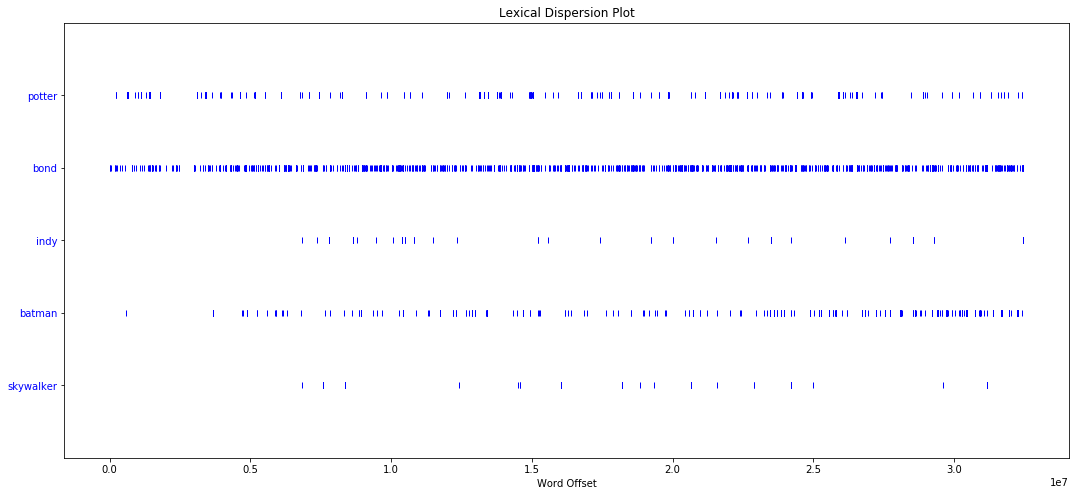

In [51]:
plt.figure(figsize=(18, 8)) #, dpi= 80, facecolor='w', edgecolor='k')
fig = nltk_all_movies_over_time.dispersion_plot(["potter", "bond", "indy", "batman", "skywalker"])

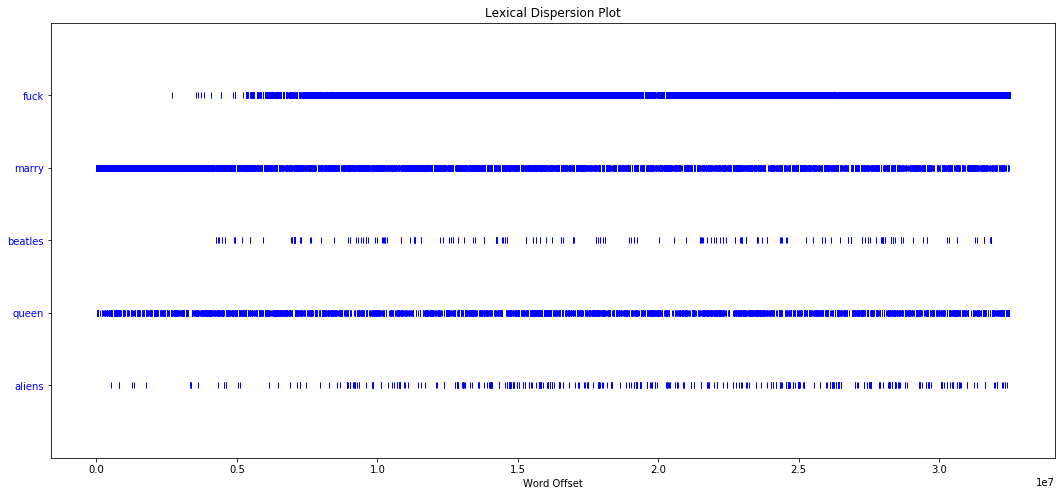

In [52]:
plt.figure(figsize=(18, 8)) #, dpi= 80, facecolor='w', edgecolor='k')
fig = nltk_all_movies_over_time.dispersion_plot(["fuck", "marry", "beatles", "queen", "aliens"])

In [53]:
# words over time for only the chosen directors

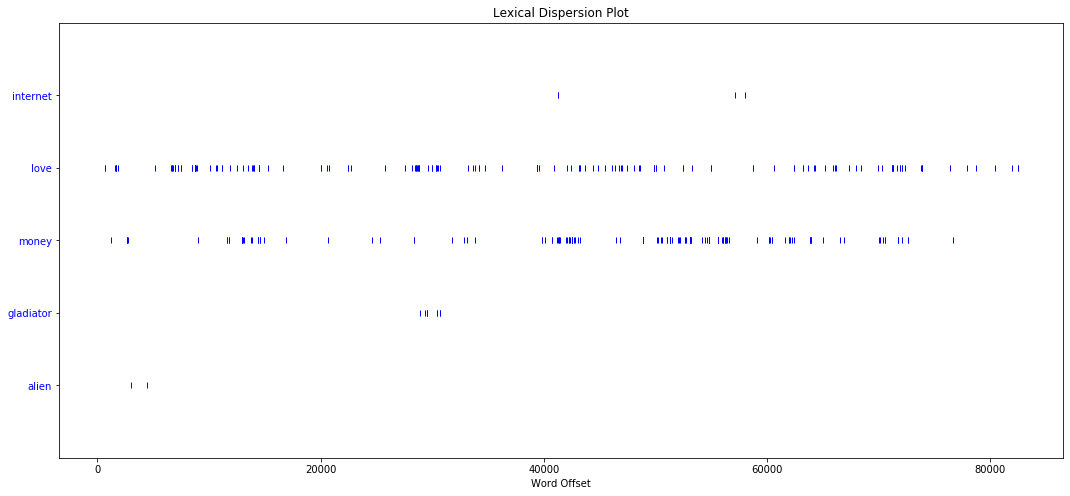

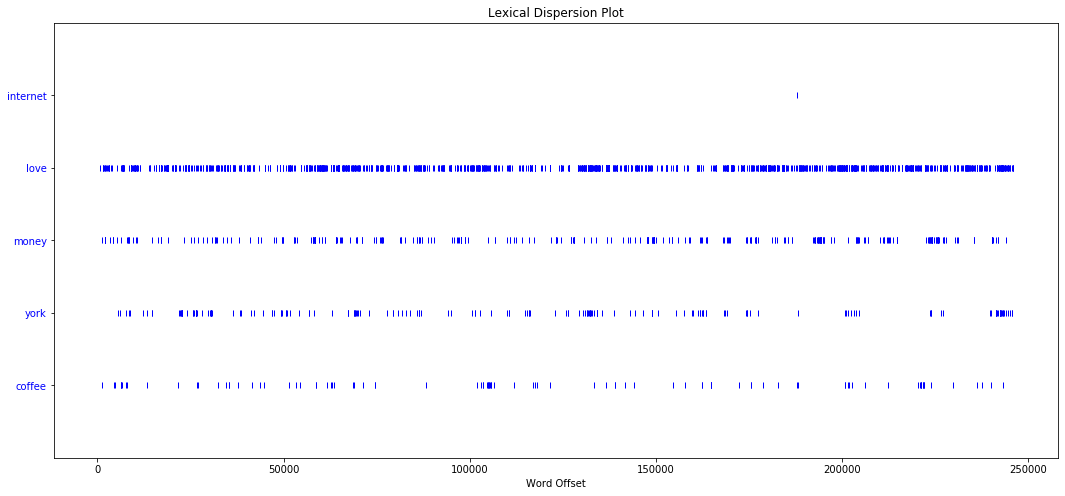

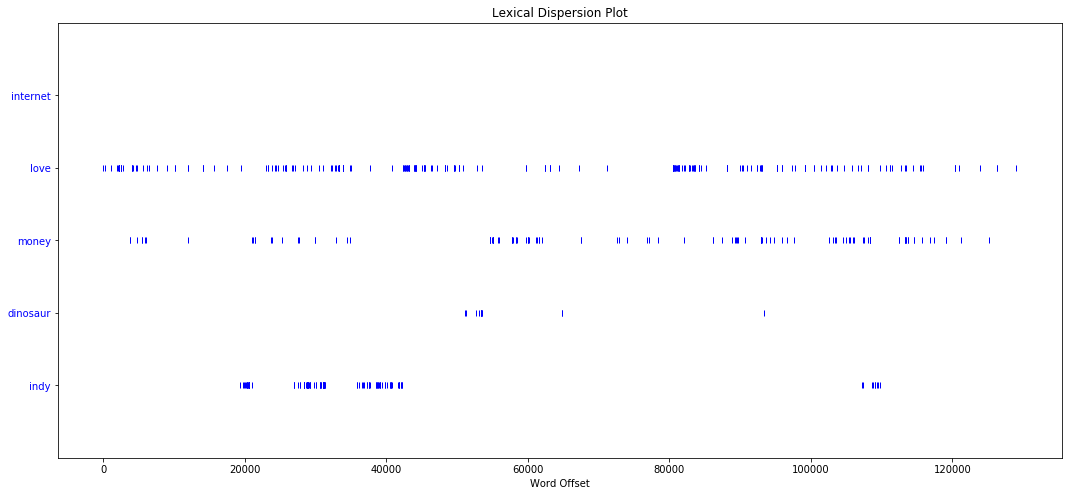

In [86]:
dispersion_words = [
    ["internet","love","money","gladiator","alien"], # Ridley Scott
    ["internet","love","money","york","coffee"], # Woody Allen
    ["internet","love","money","dinosaur","indy"] # Stiven Spilberg
]

for ind,director in enumerate(central_directors):
    director_work_list = director_to_work[director]
    director_tokens = list()
    for reldate,movie in ordered_movies_by_rel_date:
        if movie in director_work_list:
            director_tokens += list(movie_to_tokens[movie])
    
    nltk_dir_list = nltk.Text(director_tokens)
    plt.figure(figsize=(18, 8)) #, dpi= 80, facecolor='w', edgecolor='k')
    fig = nltk_dir_list.dispersion_plot(dispersion_words[ind])

    

In [55]:
# comunity sentiment and word cloud analysis

/Users/lukaavbreht/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: MatplotlibDeprecationWarning: Unrecognized location 'community1 community2 community3 community4 community5 community6'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


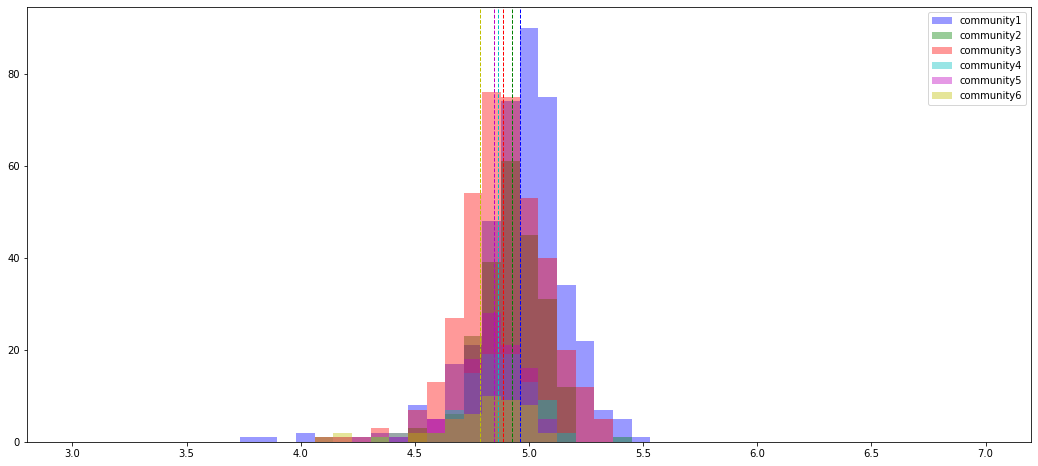

In [85]:
# load communities
comunity_file_path = "data/communities.csv"

communities = [list() for _ in range(6)]
kk = 2
with open(comunity_file_path, "r") as iinput:
    iinput.readline()
    for line in iinput:
        loaded_community = line.strip().split(",")
        kk+=1
        for ind,name in enumerate(loaded_community[1:]):
            if name == "George Tillman Jr.":
                name = "George Tillman, Jr."
            communities[ind].append(name)
    
bins = np.linspace(3,7, 50)
numpy_communities = list()
legend_loc = ""
ind = 1
colo = ["b","g","r","c","m","y"]

plt.figure(figsize=(18, 8)) #, dpi= 80, facecolor='w', edgecolor='k')
for community in communities:
    temp_director_sentiment_comunity = list()
    for director in community:
        try:
            temp_director_sentiment_comunity.append(directors_to_sentiment[director])
        except:
            pass
    legend_loc += " community{0}".format(ind) 
    
    numpy_communities.append(np.array(temp_director_sentiment_comunity))
    plt.hist(temp_director_sentiment_comunity, bins, alpha=0.4,color=colo[ind-1], label='community{0}'.format(ind))
    ind += 1
    
ind = 0
for comun in numpy_communities:
    mmean = comun.mean()
    plt.axvline(mmean, color=colo[ind], linestyle='dashed', linewidth=1)
    # plt.text(mmean + 0.003,100,"community{0}".format(ind+1) ,rotation=90,color="black")
    ind += 1

plt.legend(loc=legend_loc[1:])
plt.show()



In [83]:
ind = 1
for comun in numpy_communities:
    mmean = comun.mean()
    sstd = comun.std()
    
    print("Community{0} has mean sentiment of {1:.4f}".format(ind,mmean))
    print("Community{0}'s sentiment standard deviation is {1:.4f}".format(ind,sstd))
    ind += 1


Community1 has mean sentiment of 4.9592
Community1's sentiment standard deviation is 0.2111
Community2 has mean sentiment of 4.9248
Community2's sentiment standard deviation is 0.1334
Community3 has mean sentiment of 4.8870
Community3's sentiment standard deviation is 0.1835
Community4 has mean sentiment of 4.8646
Community4's sentiment standard deviation is 0.1519
Community5 has mean sentiment of 4.8463
Community5's sentiment standard deviation is 0.1372
Community6 has mean sentiment of 4.7859
Community6's sentiment standard deviation is 0.2184
